In [3]:
# Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kp_image
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools
from sklearn.utils import shuffle
import requests
from io import BytesIO
from PIL import Image

**Neural Style Transfer**

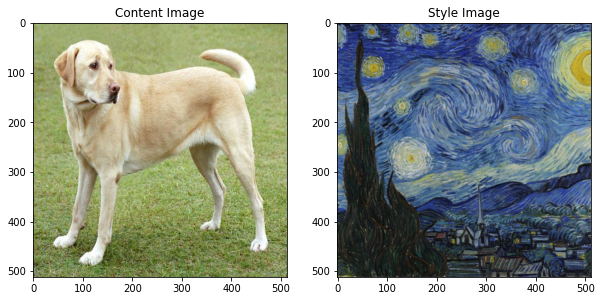

Iteration: 0
Total loss: 4.2959e+07, Style loss: 2.1979e+07, Content loss: 2.0981e+07
Iteration: 100
Total loss: 1.3474e+07, Style loss: 3.9075e+05, Content loss: 1.3084e+07
Iteration: 200
Total loss: 1.2981e+07, Style loss: 2.4315e+05, Content loss: 1.2738e+07
Iteration: 300
Total loss: 1.2977e+07, Style loss: 3.1716e+05, Content loss: 1.2659e+07
Iteration: 400
Total loss: 1.2708e+07, Style loss: 1.7786e+05, Content loss: 1.2530e+07
Iteration: 500
Total loss: 1.2761e+07, Style loss: 2.6055e+05, Content loss: 1.2501e+07
Iteration: 600
Total loss: 1.2654e+07, Style loss: 1.8705e+05, Content loss: 1.2467e+07
Iteration: 700
Total loss: 1.2615e+07, Style loss: 1.5859e+05, Content loss: 1.2457e+07
Iteration: 800
Total loss: 1.2536e+07, Style loss: 1.3652e+05, Content loss: 1.2400e+07
Iteration: 900
Total loss: 1.2540e+07, Style loss: 1.4519e+05, Content loss: 1.2395e+07


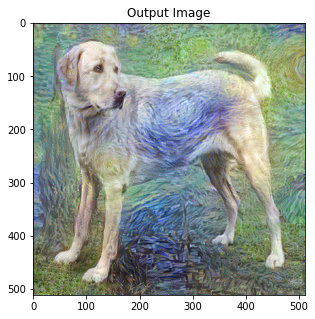

In [4]:
# Load the images from URLs and resize to a fixed size
def load_img_from_url(url, img_size=(512, 512)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(img_size, Image.LANCZOS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

style_url = "https://storage.googleapis.com/kaggle-datasets-images/133/275/a6c2e389f50dfb5bbc76705e893a6c10/dataset-card.png"

style_image = load_img_from_url(style_url)


# Load the images from file paths and resize to a fixed size
def load_img_from_path(path, img_size=(512, 512)):
    img = Image.open(path)
    img = img.resize(img_size, Image.LANCZOS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Use keras utility to download images
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

content_image = load_img_from_path(content_path)



# Display the images
def imshow(img, title=None):
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title:
        plt.title(title)
    plt.imshow(out)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.show()

# Preprocessing for VGG19 model
def preprocess_image(img):
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Load VGG19 model
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Content and Style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Model for extracting style and content
def get_model():
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return Model(inputs=vgg.input, outputs=model_outputs)

# Compute content loss
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Compute style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Compute total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):    
    style_weight, content_weight = loss_weights
    
    # Feed our init image through our model. This will give us the content and
    # style representations at our desired layers.
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    # Accumulate style losses from all layers
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    # Accumulate content losses from all layers
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
    
    # Combine the style and content losses
    style_score *= style_weight
    content_score *= content_weight
    
    # Compute the total loss
    total_loss = style_score + content_score
    return total_loss, style_score, content_score

# Extract style and content features
def get_feature_representations(model, content_image, style_image):
    content_image = preprocess_image(content_image)
    style_image = preprocess_image(style_image)
    
    stack_images = tf.concat([content_image, style_image], axis=0)
    features = model(stack_images)
    
    style_features = features[:num_style_layers]
    content_features = features[num_style_layers:]
    
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    return gram_style_features, content_features

# Style transfer using gradient descent
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Main function to perform style transfer
def run_style_transfer(content_image, style_image, num_iterations=1000, content_weight=1e4, style_weight=1e-2):
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
    
    style_features, content_features = get_feature_representations(model, content_image, style_image)
    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5.0)
    
    iter_count = 1
    best_loss, best_img = float('inf'), None
    loss_weights = (style_weight, content_weight)
    
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': style_features,
        'content_features': content_features
    }
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_image(init_image.numpy())
        
        if i % 100 == 0:
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, Style loss: {:.4e}, Content loss: {:.4e}'.format(loss, style_score, content_score))
    
    return best_img, best_loss


best, best_loss = run_style_transfer(content_image, 
                                     style_image, num_iterations=1000 )

plt.figure(figsize=(10, 5))
plt.imshow(best)
plt.title('Output Image')
plt.show()


**Feature Extraction Using Pre-trained Model (GoogleNet)**

In [5]:
# Load GoogleNet model
base_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

def extract_features(image):
    preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(image)
    features = base_model.predict(preprocessed_image)
    return features

# Extract features
content_feature = extract_features(content_image)
stylized_feature = extract_features(np.expand_dims(best, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


**Implementing Contrastive Learning**

In [6]:
# Create positive and negative pairs
positive_pair = (content_feature, stylized_feature)
negative_pair = (content_feature, content_feature)  # Simulating a negative pair for the sake of the example

def contrastive_loss(features1, features2, positive=True, temperature=0.1):
    similarity = tf.keras.losses.cosine_similarity(features1, features2)
    if positive:
        return -tf.math.log(tf.math.exp(-similarity) / (tf.math.exp(-similarity) + tf.math.exp(similarity)))
    else:
        return -tf.math.log(tf.math.exp(similarity) / (tf.math.exp(similarity) + tf.math.exp(-similarity)))

# Compute contrastive loss
positive_loss = contrastive_loss(positive_pair[0], positive_pair[1], positive=True)
negative_loss = contrastive_loss(negative_pair[0], negative_pair[1], positive=False)

total_loss = positive_loss + negative_loss


**Freezing the Trained Model**

In [7]:
# Simulate additional data (data augmentation)
def augment_image(image):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.2),
    ])
    return data_augmentation(image)

augmented_images = [augment_image(content_image) for _ in range(10)]
augmented_features = [extract_features(augmented_image) for augmented_image in augmented_images]

# Prepare training data
X_train = np.vstack((content_feature, stylized_feature, *augmented_features))
y_train = np.hstack((0, 1, *[0]*len(augmented_features)))

# Freeze the base model
base_model.trainable = False


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


**Training a Linear Classifier**

In [8]:
# Create and train a linear classifier model
classifier_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classifier_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the classifier
classifier_model.fit(X_train, y_train, epochs=10, batch_size=2)

# Evaluate the model on the training set
loss_train, accuracy_train = classifier_model.evaluate(X_train, y_train)

print(f'Classifier accuracy on training set: {accuracy_train * 100:.2f}%')

# Load the content image for the test set
content_path_test = tf.keras.utils.get_file('LabradorRetriever.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image_test = load_img_from_path(content_path_test)

# Perform style transfer on the test content image
best_test, best_loss_test = run_style_transfer(content_image_test, style_image, num_iterations=100)

# Extract features for the test content and stylized images
content_feature_test = extract_features(content_image_test)
stylized_feature_test = extract_features(np.expand_dims(best_test, axis=0))

# Prepare the test data
X_test = np.vstack((content_feature_test, stylized_feature_test))
y_test = np.array([0, 1])  # Ground truth labels for the test data

# Evaluate the model on the test set
loss_test, accuracy_test = classifier_model.evaluate(X_test, y_test)

print(f'Classifier accuracy on test set: {accuracy_test * 100:.2f}%')


Epoch 1/10


C:\Users\abdinlinezrin\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 0s/step - accuracy: 0.3988 - loss: 0.8529   
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.9762 - loss: 0.3652
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.1829 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8845 - loss: 0.3464 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9619 - loss: 0.1214 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9762 - loss: 0.0844 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9202 - loss: 0.1459  
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 1.0000 - loss: 0.0639  
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 1.0000 - loss: 0.0790  
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 1.0000 - loss: 0.0597  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0856
Classifier accuracy on training set: 100.00%
Iteration: 0
Total loss: 2.9797e+08, Style loss: 2.6176e+08,

**Evaluating the Model**

In [9]:
# Evaluate the model
loss, accuracy = classifier_model.evaluate(X_train, y_train)

print(f'Classifier accuracy: {accuracy * 100:.2f}%')


y_pred = classifier_model.predict(X_train).round()
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0856
Classifier accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
